In [1]:
%matplotlib inline

In [2]:
import pathlib

import pandas

from matplotlib import pylab

from multiprocessing import Pool

from kaskady2.analyze.profile import *
from kaskady2.analyze.profile_fits import *
from kaskady2.loader.reader import CascadeSetLoader



In [3]:
cascades = CascadeSetLoader.find_cascades(
  pathlib.Path('/home/jb/kaskady-data/g4-production')
)

In [4]:
fits_dir = pathlib.Path("/tmp/fits")

fits_dir.mkdir(exist_ok=True)


In [5]:
fit_function = LongitudinalProfileFitFunction()
    

In [6]:
def doFit(loader):
    import numpy as np
    file = loader.main_geometry
    avg_profile = file.get_longitudinal_average_profile()
    fit_data_full = LongitudinalProfileFitData(avg_profile)    
    fit_data = FitDataWrapper(fit_data_full, fit_until_deposition_reaches=0.9995)
    fit_function = LongitudinalProfileFitFunction()
    
    try: 
        fit_obj = FitObject(fit_data, fit_function)
        pars, pcov = fit_obj.do_fit()
    except RuntimeError: 
        return (False, loader.config, None, fit_data, None)
    
    pylab.clf()
    pylab.plot(fit_data_full.xdata, fit_data_full.ydata)
    fitted_y = fit_function.fit_function(fit_data.xdata, *pars)
    pylab.plot(fit_data_full.xdata, fit_data_full.ydata)
    pylab.plot(fit_data.xdata, fitted_y)
    pylab.yscale('log')
    pylab.ylim(1E-5, 1.3*np.max(fit_data_full.ydata))
    pylab.savefig(str(fits_dir / "{}.png".format("-".join((map(str, (
      loader.config.run_info.energy_mev, loader.config.material.name, loader.config.ecuts.energy_kev)))
    ))))
    
    fitted_full = fit_function.fit_function(fit_data_full.xdata, *pars)
    
    chisq = chisquare_test(fit_data_full.ydata, fitted_full, fit_data_full.sigma[0], 5)
        
    return (True,  loader.config, pars, fit_data, chisq)
    
    

(True,
 <Config version=(1, 1, 0) run_info=RunInfo(particle=<InitialParticle.GAMMA: 'GAMMA'>, incidents=15000, energy_mev=11000) material=Material(name='G4_BGO', w_coeff=17.0779049125405, density_g_cm3=7.13, rad_len_mm=11.18008168663319) cuts=Cuts(type=<CutsType.G4Cuts: 'G4Cuts'>, energy_kev=3000)>,
 array([ 10.15069053,   8.31765876,   0.55146859,   5.05521021,   0.9356723 ]),
 ChisquareTestResult(prob=0.0, chisq_sum=memmap(29.250236290633566), sum_elems=memmap([  4.82310016e+02,   1.26123678e+02,   2.13041361e+02,
         1.79643669e+02,   1.48379727e+02,   1.51734695e+02,
         1.35964462e+02,   8.78655836e+01,   5.29963628e+01,
         3.49814060e+01,   1.54535962e+01,   6.20327286e+00,
         1.01860130e+00,   1.28845153e-02,   1.80951880e+00,
         1.43257207e+01,   2.74307075e+01,   3.99887756e+01,
         3.95010026e+01,   6.23667957e+01,   9.03636608e+01,
         9.59446116e+01,   1.04191341e+02,   8.92400164e+01,
         8.47781465e+01,   8.17939667e+01,   9.6178

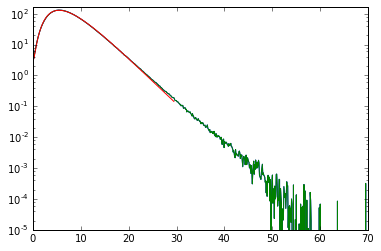

In [7]:
doFit(cascades[0])

In [8]:
pool = Pool(processes=8)     

In [9]:
result = pool.map_async(doFit, cascades)

In [12]:
result.wait(timeout=120)

In [17]:
results = result.get()

In [18]:
results[2]
config = results[0][1]
results[1][-1]

ChisquareTestResult(prob=0.0, chisq_sum=memmap(876063.7699397702), sum_elems=memmap([  3.86324245e+02,   1.87008302e+02,   1.74635242e+02,
         1.53337798e+02,   1.18928100e+02,   1.11378083e+02,
         5.67313320e+01,   4.50979215e+01,   2.40434324e+01,
         1.55379024e+01,   7.06539130e+00,   3.04521261e-01,
         2.64168642e+00,   3.93036526e+00,   1.22728258e+01,
         1.65757733e+01,   2.29751167e+01,   4.32714073e+01,
         5.41401242e+01,   5.43153888e+01,   5.91427584e+01,
         7.04615136e+01,   6.33406936e+01,   6.19668099e+01,
         5.71002285e+01,   5.56388939e+01,   4.75587953e+01,
         5.04868765e+01,   6.05120257e+01,   4.12234475e+01,
         3.58769291e+01,   2.74229433e+01,   1.67584133e+01,
         1.34169384e+01,   6.77418685e+00,   8.42564844e+00,
         4.34673560e+00,   5.25262550e+00,   1.36123048e+00,
         1.89090013e+00,   5.45359879e-01,   3.29548856e-01,
         7.38245382e-01,   2.95187487e+00,   2.31811495e+00,
       

In [19]:
def extract_data(row): 
    fit_ok = row[0]
    config = row[1]
    pars = row[2]
    fit_data = row[3]
    chisq = row[4]
    
    row = {
        "material": config.material.name, 
        "ecuts_kev": config.ecuts.energy_kev, 
        "energy_mev": config.run_info.energy_mev, 
        "fit_ok": fit_ok,
        "chisq_sum": chisq[1] if fit_ok else None
    }
    
    for idx, name in  enumerate(['alpha', 'beta', 'gamma', 'delta', 'epsilon']): 
        if fit_ok:
            row[name] = pars[idx]
        else: 
            row[name] = None
            
    return row    

table = pandas.DataFrame(data = [
    extract_data(row)
    for row in results
])

In [20]:
table = table.sort(['material', 'ecuts_kev', 'energy_mev']).set_index(drop=False, keys=['material', 'ecuts_kev', 'energy_mev'])
table

/home/jb/programs/kaskady2.0/venv/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


alpha      beta           chisq_sum  \
material ecuts_kev energy_mev                                             
G4_BGO   600       100                NaN       NaN                None   
                   120                NaN       NaN                None   
                   145          98.731985  1.831719  19089829.681295704   
                   175         114.140884  2.176325  20935064.740506943   
                   210         116.776841  2.495077  31523242.796922144   
                   255         154.959066  2.907572   7285640.105544226   
                   310         132.803905  3.191377   61579.86513508922   
                   375         220.209661  3.676125   77103.83270070143   
                   455         131.817050  3.859543  1322353.9149555287   
                   555         150.848909  4.228312  1001416.9415153784   
                   680         139.070166  4.536606   52061007.77714543   
                   875         126.776517  4.958081  33898484.373622656   
                   1125         88.374465  5.236472   46495153.48682315   
                   1375        104.459628  5.619311   984946.4614586007   
                   1625         79.491835  5.850028  44379736.993671834   
                   1875         69.312078  6.046809  1122899.5062783698   
                   2125         61.249908  6.215282   288702712.0818564   
                   2375         52.167226  6.296772  406384.74327497947   
                   2625         47.779407  6.495108   754871.2322702246   
                   2875         45.879974  6.621963  288648.65241797245   
                   3125         37.502810  6.705211   758217.9963738379   
                   3375         36.900084  6.838381   534694.1895771354   
                   5000         19.258875  7.294876   15459.88119760666   
                   7000         13.944021  7.756717   4482197.340842973   
                   9000          9.577057  8.090801  3438465.7657738933   
                   11000         7.101078  8.416758  3449.2536712340175   
         1200      100                NaN       NaN                None   
                   120                NaN       NaN                None   
                   145         115.737651  1.818445   3714611.828522909   
                   175         133.871964  2.189262   13865700.49135992   
...                                   ...       ...                 ...   
xenon    2000      5000         56.074195  7.308672   81358.83706217095   
                   7000         36.325643  7.761289  12.263204108265437   
                   9000         27.698883  8.125552  14.656585178817682   
                   11000        19.475793  8.319638   18.10063529801855   
         3000      100                NaN       NaN                None   
                   120                NaN       NaN                None   
                   145                NaN       NaN                None   
                   175         820.920353  2.438861   462608.8546728212   
                   210         670.244871  2.726711   656946.0132366389   
                   255         574.799962  2.984833  21.348060389080498   
                   310         431.316206  3.248206   28.23743129123527   
                   375         421.836533  3.601362   759.2298330577407   
                   455         340.467704  3.873197  178525.48879602528   
                   555         400.210384  4.236288  10.379314321733428   
                   680         394.741725  4.597289   498.0566576934483   
                   875         295.043793  4.966750  278579.18504210515   
                   1125        306.619974  5.382328   9.159955748097495   
                   1375        251.390823  5.636107  12.214734444982838   
                   1625        207.590981  5.908754    16.8173182156682   
                   1875        180.868778  6.118237   20.44073951310283   
                   2125        151.304313  6.249573   8.62126

In [21]:
for mat in table.material.unique(): 
    filtered = table.loc[mat]
    for ecut in filtered.ecuts_kev.unique(): 
        filtered = table.loc[mat]
        filtered = filtered.loc[ecut]
        for param in ['alpha', 'beta', 'gamma', 'delta', 'epsilon']:
            series = filtered[param]
            pylab.clf()
            series.plot()
            pylab.ylabel(param)
            pylab.title("Energy dependency of {} in {} for {}".format(param, mat, ecut))
            pylab.savefig("/tmp/fits/{}-{}-{}.png".format(mat, param, ecut))

In [22]:
table.to_excel('/tmp/fits/fits.xls')